In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
import pandas as pd

In [2]:
_parent_folder = "multi_cam_nov_14"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\recording_programs\\test_data\\multi_cam_nov_14'

In [6]:
""" read excel sheet"""
folder_df = pd.read_excel(os.path.join(_base_pth, "00_analysis", "calibration_files.xlsx"))
folder_df

,folder_name,calibration_folder,flip
0,sk16_15_forward_fast,calibration_15fps_sk,False
1,sk16_15_forward_fast_2,calibration_15fps_sk,False
2,sk16_15_forward_medium,calibration_15fps_sk,False
3,sk16_15_forward_medium_2,calibration_15fps_sk,False
4,sk16_15_forward_slow,calibration_15fps_sk,False
...,...,...,...
84,sk16_60_sideways_fast_2,calibration_60fps_quad_sk_3,False
85,sk16_60_sideways_medium,calibration_60fps_quad_sk_3,False
86,sk16_60_sideways_medium_2,calibration_60fps_quad_sk_3,False
87,sk16_60_sideways_slow,calibration_60fps_quad_sk_3,False


In [50]:
#open the calibration files
_pth = folder_df.folder_name[0]
_pth = os.path.join(_base_pth, _pth)

#read the calibration file
_webcam_calib_folder = folder_df.calibration_folder[0]
_webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)
_webcam_calib_pth = os.path.join(_base_pth, _webcam_calib_folder, "webcam_calibration.msgpack")


with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]
_webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")
_webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")


with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)
print("camera matrix", _webcam_cam_mat)
print("distortion", _webcam_dist)

camera matrix [[874.59046783   0.         366.44018221]
 [  0.         881.45673935 268.42500753]
 [  0.           0.           1.        ]]
distortion [[ 1.29040791e-01 -1.00989575e-01  8.05214561e-03  2.63742822e-03
  -5.99529755e+00]]


In [59]:
_w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=True)

_w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)


returning dataframe


In [46]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val - translation_correction
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [61]:
w_df = transform_coordinates_1(_w_df, _webcam_rot, _webcam_org)

In [22]:
mc_df_pth = os.path.join(_base_pth, folder_df.folder_name[0].split("_")[0], folder_df.folder_name[0]+ ".csv")
_m_df, st_time = read_df_csv(mc_df_pth)

In [23]:
_m_df["x"] = _m_df["lb_x"] + _m_df["rb_x"] + _m_df["lt_x"] + _m_df["rt_x"]
_m_df["y"] = _m_df["lb_y"] + _m_df["rb_y"] + _m_df["lt_y"] + _m_df["rt_y"]
_m_df["z"] = _m_df["lb_z"] + _m_df["rb_z"] + _m_df["lt_z"] + _m_df["rt_z"]

_m_df["x"] = _m_df["x"] / 4
_m_df["y"] = _m_df["y"] / 4
_m_df["z"] = _m_df["z"] / 4

_m_df = add_datetime_col(_m_df, st_time,_name="seconds")

webcam
2.135321


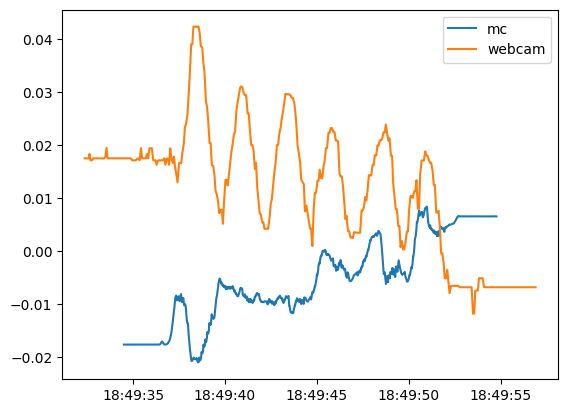

In [62]:
# which starts earlier

if _w_df["time"].iloc[0] > _m_df["time"].iloc[0]:
    _start_time = _m_df["time"].iloc[0]

    # time difference
    _time_diff = _w_df["time"].iloc[0] - _m_df["time"].iloc[0]
    print("mc")
else:
    _start_time = _w_df["time"].iloc[0]
    _time_diff = _m_df["time"].iloc[0] - _w_df["time"].iloc[0]
    print("webcam")

plt.plot(_m_df["time"], _m_df["x"], label="mc")
plt.plot(_w_df["time"], w_df["x"], label="webcam")
plt.legend()
print(_time_diff.total_seconds())